In [6]:
# CELL 1: Download adult.data if it doesn't exist
import urllib.request
import os

url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data'
filename = 'adult.data'

if not os.path.exists(filename):
    print("Downloading adult.data...")
    urllib.request.urlretrieve(url, filename)
    print("Download complete!")
else:
    print("adult.data already exists.")

Download complete!


In [7]:
# -*- coding: utf-8 -*-
"""
MSCS 634 – Deliverable 1
Data Collection, Cleaning & Exploratory Data Analysis
Dataset: UCI Adult Income
"""

# ==============================
# 1. IMPORTS & SETUP
# ==============================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')
sns.set(style="whitegrid", font_scale=1.1)
%matplotlib inline

# ==============================
# 2. LOAD DATASET
# ==============================
# Column names from UCI description
cols = [
    'age', 'workclass', 'fnlwgt', 'education', 'education_num',
    'marital_status', 'occupation', 'relationship', 'race', 'sex',
    'capital_gain', 'capital_loss', 'hours_per_week', 'native_country', 'income'
]

# '?' represents missing values
df = pd.read_csv(
    'adult.data',
    names=cols,
    na_values=' ?',
    skipinitialspace=True
)

print(f"Dataset loaded: {df.shape[0]:,} rows × {df.shape[1]} columns")
df.head()

Dataset loaded: 32,561 rows × 15 columns


,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [8]:
# ==============================
# 3. INITIAL INSPECTION
# ==============================
print("\n--- Data Types ---")
print(df.dtypes)

print("\n--- Missing Values ---")
print(df.isnull().sum())

print("\n--- Duplicates ---")
print(f"Duplicate rows: {df.duplicated().sum()}")


--- Data Types ---
age                int64
workclass         object
fnlwgt             int64
education         object
education_num      int64
marital_status    object
occupation        object
relationship      object
race              object
sex               object
capital_gain       int64
capital_loss       int64
hours_per_week     int64
native_country    object
income            object
dtype: object

--- Missing Values ---
age               0
workclass         0
fnlwgt            0
education         0
education_num     0
marital_status    0
occupation        0
relationship      0
race              0
sex               0
capital_gain      0
capital_loss      0
hours_per_week    0
native_country    0
income            0
dtype: int64

--- Duplicates ---
Duplicate rows: 24


In [9]:
# ==============================
# 4. DATA CLEANING
# ==============================
# 4.1 Drop duplicates (if any)
df.drop_duplicates(inplace=True)

# 4.2 Handle missing values
# Critical categorical columns: drop rows where both workclass & occupation are missing
missing_critical = df['workclass'].isnull() & df['occupation'].isnull()
print(f"Dropping {missing_critical.sum()} rows with missing workclass+occupation")
df = df[~missing_critical]

# Impute native_country with mode
mode_country = df['native_country'].mode()[0]
df['native_country'].fillna(mode_country, inplace=True)

# Verify
print("\nMissing after cleaning:")
print(df.isnull().sum())

Dropping 0 rows with missing workclass+occupation

Missing after cleaning:
age               0
workclass         0
fnlwgt            0
education         0
education_num     0
marital_status    0
occupation        0
relationship      0
race              0
sex               0
capital_gain      0
capital_loss      0
hours_per_week    0
native_country    0
income            0
dtype: int64


In [10]:
# 4.3 Strip whitespace (safety)
str_cols = df.select_dtypes(include='object').columns
df[str_cols] = df[str_cols].apply(lambda x: x.str.strip() if x.dtype == "object" else x)

# 4.4 Outlier capping for capital_gain/loss (99th percentile)
for col in ['capital_gain', 'capital_loss']:
    p99 = df[col].quantile(0.99)
    df[col] = df[col].clip(upper=p99)
    print(f"{col} capped at 99th percentile: {p99}")

# 4.5 Create useful flags
df['has_capital_gain'] = (df['capital_gain'] > 0).astype(int)
df['has_capital_loss'] = (df['capital_loss'] > 0).astype(int)

# Log-transform (after adding 1 to handle zeros)
df['log_cap_gain'] = np.log1p(df['capital_gain'])
df['log_cap_loss'] = np.log1p(df['capital_loss'])

capital_gain capped at 99th percentile: 15024.0
capital_loss capped at 99th percentile: 1980.0


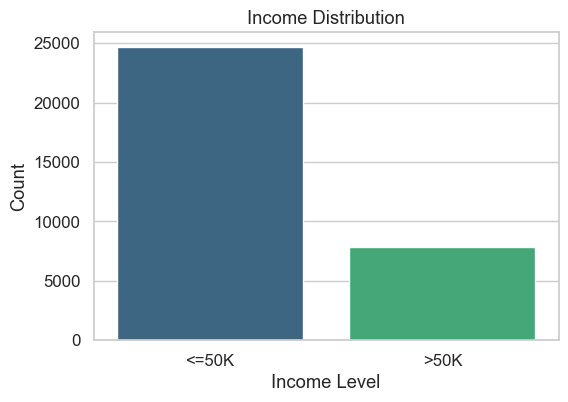

income
<=50K    0.759074
>50K     0.240926
Name: proportion, dtype: float64


In [11]:
# ==============================
# 5. EXPLORATORY DATA ANALYSIS
# ==============================
# 5.1 Target distribution
plt.figure(figsize=(6,4))
sns.countplot(x='income', data=df, palette='viridis')
plt.title('Income Distribution')
plt.xlabel('Income Level')
plt.ylabel('Count')
plt.show()

print(df['income'].value_counts(normalize=True))

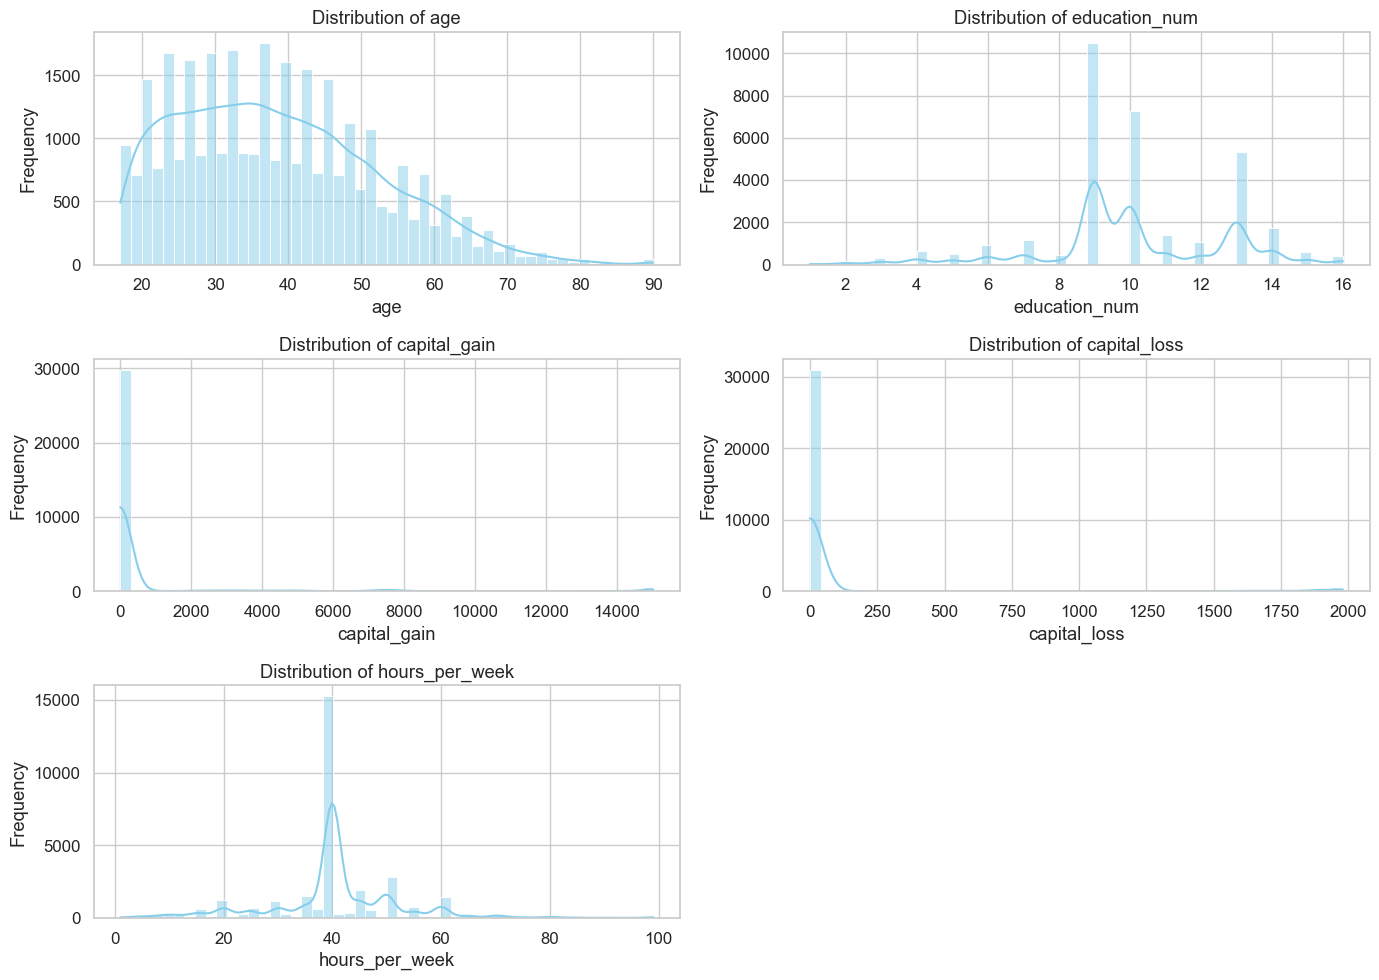

In [12]:
# 5.2 Numeric feature distributions
num_cols = ['age', 'education_num', 'capital_gain', 'capital_loss', 'hours_per_week']

plt.figure(figsize=(14,10))
for i, col in enumerate(num_cols, 1):
    plt.subplot(3,2,i)
    sns.histplot(df[col], kde=True, bins=50, color='skyblue')
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

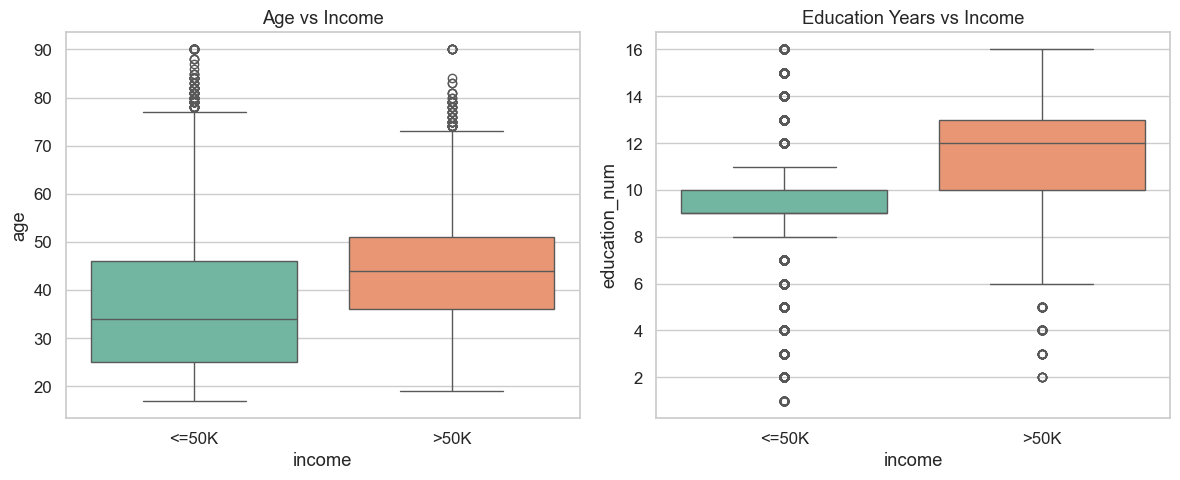

In [13]:
# 5.3 Relationship with target (boxplots)
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.boxplot(x='income', y='age', data=df, palette='Set2')
plt.title('Age vs Income')

plt.subplot(1,2,2)
sns.boxplot(x='income', y='education_num', data=df, palette='Set2')
plt.title('Education Years vs Income')
plt.tight_layout()
plt.show()

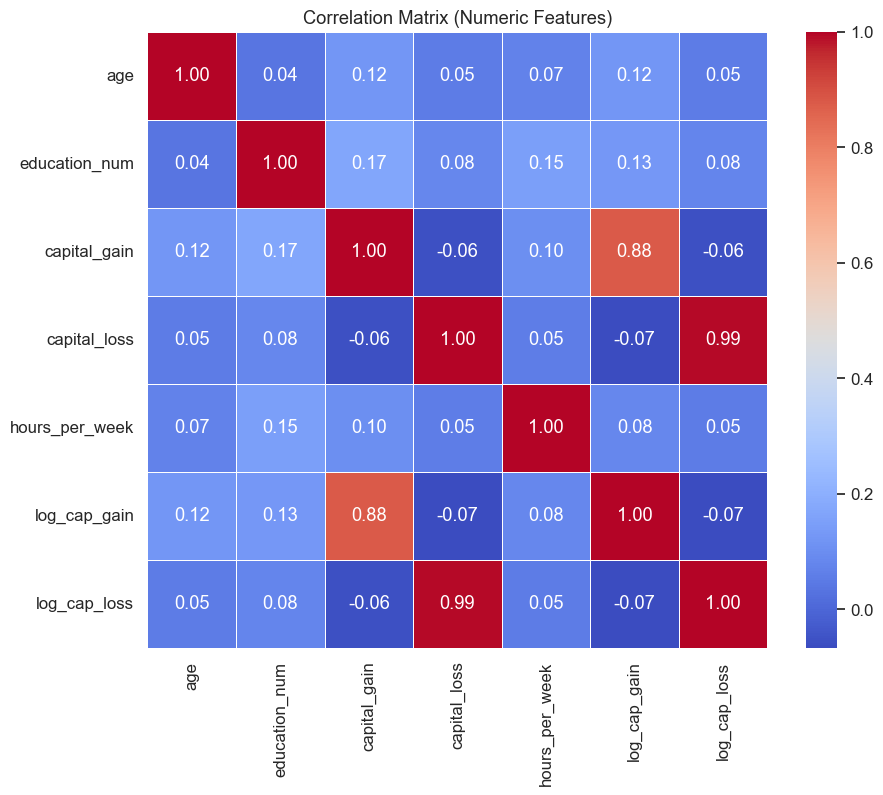

In [14]:
# 5.4 Correlation heatmap (numeric only)
corr = df[num_cols + ['log_cap_gain', 'log_cap_loss']].corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
plt.title('Correlation Matrix (Numeric Features)')
plt.show()

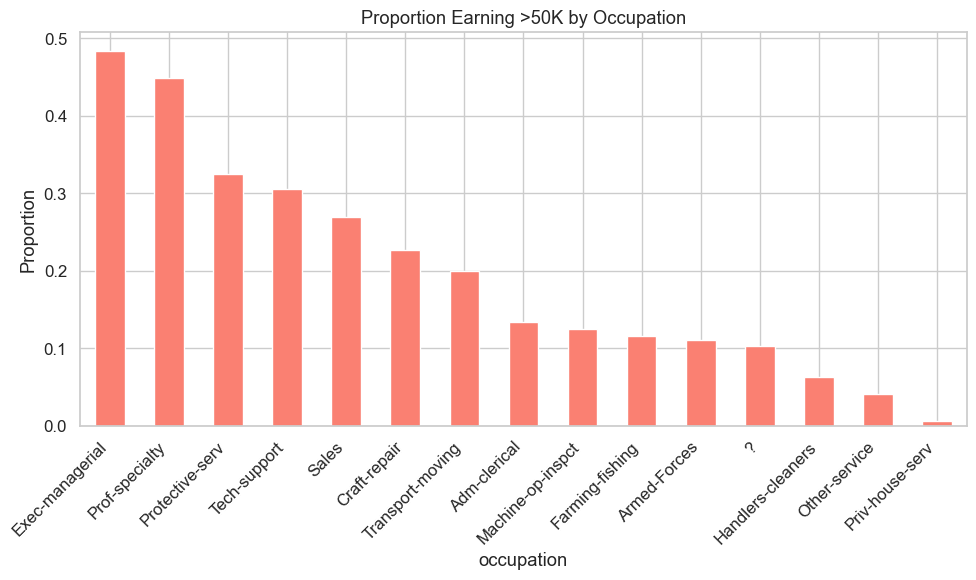

In [15]:
# 5.5 Categorical insights – occupation vs income
occ_income = (df.groupby('occupation')['income']
              .value_counts(normalize=True)
              .unstack()
              .sort_values('>50K', ascending=False))

plt.figure(figsize=(10,6))
occ_income['>50K'].plot(kind='bar', color='salmon')
plt.title('Proportion Earning >50K by Occupation')
plt.ylabel('Proportion')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [16]:
# 5.6 Native country imbalance
country_counts = df['native_country'].value_counts(normalize=True)
print("Top 5 countries:")
print(country_counts.head())

# Group rare countries
threshold = 0.01  # 1%
other_countries = country_counts[country_counts < threshold].index
df['native_country_grouped'] = df['native_country'].replace(other_countries, 'Other')

Top 5 countries:
native_country
United-States    0.895995
Mexico           0.019639
?                0.017887
Philippines      0.006085
Germany          0.004211
Name: proportion, dtype: float64


In [17]:
# ==============================
# 6. INSIGHTS SUMMARY
# ==============================
insights = """
### Key EDA Insights
1. **Target imbalance**: ~24% earn >50K → consider class-weighting or SMOTE in modeling.
2. **Education-num** is the strongest numeric predictor (median 10 for <=50K, 13 for >50K).
3. **Capital gain/loss** are sparse; log-transform + flag features will help regression.
4. **Occupation** matters: Exec-managerial & Prof-specialty have highest >50K rates.
5. **Age & hours-per-week** show moderate separation; interaction terms may help.
6. **Native-country** is dominated by United-States (91%+); grouping rare countries reduces cardinality.
"""

print(insights)


### Key EDA Insights
1. **Target imbalance**: ~24% earn >50K → consider class-weighting or SMOTE in modeling.
2. **Education-num** is the strongest numeric predictor (median 10 for <=50K, 13 for >50K).
3. **Capital gain/loss** are sparse; log-transform + flag features will help regression.
4. **Occupation** matters: Exec-managerial & Prof-specialty have highest >50K rates.
5. **Age & hours-per-week** show moderate separation; interaction terms may help.
6. **Native-country** is dominated by United-States (91%+); grouping rare countries reduces cardinality.

